# Real System

In [412]:
from random import randint, seed

In [414]:
seed(1)

In [407]:
class Time:
    def __init__(self):
        self.current_time = 0
        
    def inc(self, inc):
        self.current_time += inc
        
    def get(self):
        return self.current_time
    
    def set(self, time):
        self.current_time = time

In [73]:
 class SortedList:
    def __init__(self):
        self.list = []
        
    def insert(self, e):
        length = len(self.list)
        ts = e.get_timestamp()
        i = 0
        while i < length and self.list[i].get_timestamp() < ts:
            i = i + 1
        to_insert = e
        while i < length:
            stored = self.list[i]
            self.list[i] = to_insert
            to_insert = stored
            i = i + 1
        self.list.append(to_insert)
        assert(len(self.list) == length + 1)
        
    def pop(self):
        return self.list.pop(0)

In [74]:
 class Event:
    def __init__(self, timestamp, action, job_id = -1):
        self.timestamp = timestamp
        self.action = action
        self.job_id = job_id
        
    def get_timestamp(self):
        return self.timestamp
    
    def exec_action(self):
        if self.job_id != -1:
            self.action(self.job_id)
        else:
            self.action()
            
    def __str__(self):
        return str(self.timestamp)
    
    def __repr__(self):
        return str(self.timestamp)

In [75]:
 class Job:
    job_id = 0
    def __init__(self, duration):
        self.duration = duration
        self.job_id = Job.job_id
        self.state = "undone"
        Job.job_id = Job.job_id + 1
        
        self.sub_time = None
        self.start_time = None
        self.stop_time = None
        
    def get_exec_time(self):
        return self.stop_time - self.start_time
    
    def get_wait_time(self):
        return self.start_time - self.sub_time
    
class JobBank:
    def __init__(self):
        self.jobs = {}
        
    def add_job(self, job):
        self.jobs[job_id] = job

In [114]:
class Scheduler:
    def __init__(self, resources, time, event_list):
        self.max_resources = resources
        self.current_time = 0
        self.running_jobs = {}
        self.waiting_jobs = []
        self.dict_has_been_executed = {}
        self.time = time
        self.event_list = event_list

    def get_nb_free_resources(self):
        return self.max_resources - len(self.running_jobs)
        
    def terminate_job(self, job_id):        
        # print("{}: OAR job #{} terminated".format(self.time.get(), job_id))
        self.dict_has_been_executed[job_id] = True
        self.running_jobs.pop(job_id)
        self.event_list.insert(Event(self.time.get(), self.schedule_jobs))
        
    def has_been_executed(self, job_id):
        return job_id in self.dict_has_been_executed and self.dict_has_been_executed[job_id]

    def submit_job(self, job):        
        # print("{}: OAR job #{} submitted".format(self.time.get(), job.job_id))
        self.waiting_jobs.append(job)
        self.dict_has_been_executed[job.job_id] = False
        self.event_list.insert(Event(self.time.get(), self.schedule_jobs))

    def schedule_jobs(self):
        # print("{}: Scheduling jobs".format(self.time.get()))
        nb_free_resources = self.get_nb_free_resources()
        i = 0
        initial_number_of_waiting_jobs = len(self.waiting_jobs)
        while i < initial_number_of_waiting_jobs and i < nb_free_resources:
            job = self.waiting_jobs.pop(0)
            job_id = job.job_id
            self.running_jobs[job_id] = job
            self.event_list.insert(Event(self.time.get() + job.duration, lambda j: self.terminate_job(j), job_id))
            i = i + 1     

    def log(self):
        return [self.time.get(), len(self.waiting_jobs), len(self.running_jobs)]

In [214]:
class NaiveController:
    def __init__(self, init_submission_size):
        self.submission_size = init_submission_size
        
    def get_submission_size(self):
        return self.submission_size
    
    def update_submission_size(self, _):
        pass
    
    def wait_for_previous_submission_to_finish(self):
        return True

In [382]:
class WQPIController:
    def __init__(self, kp, ki, reference, init_submission_size=0):
        self.submission_size = init_submission_size
        self.kp = kp
        self.ki = ki
        self.cumulated_error = 0
        self.reference = reference
    
    def get_submission_size(self):
        return self.submission_size
    
    def update_submission_size(self, oar_data):
        error = self.reference - oar_data[1]
        self.cumulated_error = self.cumulated_error + error
        self.submission_size = self.submission_size + self.kp * error * self.ki * self.cumulated_error
        if self.submission_size < 0:
            self.submission_size = 0
    
    def wait_for_previous_submission_to_finish(self):
        return False

In [383]:
class RunPIController:
    def __init__(self, kp, ki, reference, init_submission_size=0):
        self.submission_size = init_submission_size
        self.kp = kp
        self.ki = ki
        self.cumulated_error = 0
        self.reference = reference
    
    def get_submission_size(self):
        return self.submission_size
    
    def update_submission_size(self, oar_data):
        error = self.reference - oar_data[2]
        self.cumulated_error = self.cumulated_error + error
        self.submission_size = self.submission_size + self.kp * error * self.ki * self.cumulated_error
        if self.submission_size < 0:
            self.submission_size = 0
    
    def wait_for_previous_submission_to_finish(self):
        return False

In [384]:
class RWQPIController:
    def __init__(self, ref_wq, ref_run):
        self.cumulated_error = 0
        self.ctrl_wq  = WQPIController(0.1, 0.001, ref_wq)
        self.ctrl_run = RunPIController(0.1, 0.001, ref_run)
    
    def get_submission_size(self):
        return min(self.ctrl_wq.get_submission_size(), self.ctrl_run.get_submission_size())
    
    def update_submission_size(self, oar_data):
        self.ctrl_wq.update_submission_size(oar_data)
        self.ctrl_run.update_submission_size(oar_data)
    
    def wait_for_previous_submission_to_finish(self):
        return False

In [385]:
 def event_loop(event_list, time):
    max_time = time.get()
    while len(event_list.list) > 0:
        # print(event_list.list)
        event = event_list.pop()
        if event.timestamp == -1:
            return
        max_time = max(max_time, event.timestamp)
        # max_time = event.timestamp
        time.set(max_time)
        
        event.exec_action()
    

In [386]:
class PrioJobs:
    def __init__(self, duration, scheduler, time, event_list):
        self.duration = duration
        self.scheduler = scheduler
        self.time = time
        self.event_list = event_list
        self.jobs = {}
        
    def submit(self):
        for _ in range(randint(1, 50)):
            new_job = Job(self.duration)
            self.event_list.insert(Event(self.time.get(), lambda job: self.scheduler.submit_job(job), new_job))
            self.jobs[new_job.job_id] = self.time.get()
        next_prio_job = randint(100, 1000)
        self.event_list.insert(Event(self.time.get() + next_prio_job, self.submit))
        
    

In [387]:
class Campaign:
    campaign_id = 0
    def __init__(self, nb_jobs, duration):
        self.nb_jobs = nb_jobs
        self.nb_remaining_jobs_to_execute = nb_jobs
        self.campaign_id = Campaign.campaign_id
        Campaign.campaign_id = Campaign.campaign_id + 1
        self.generate_jobs(duration)
    
    def generate_jobs(self, duration):
        self.jobs = {}
        for _ in range(self.nb_jobs):
            job = Job(duration)
            self.jobs[job.job_id] = job

In [388]:
class CiGri:
    def __init__(self, oar_server, controller, time, event_list, sleep_time = 5):
        self.sleep_time = sleep_time
        self.campaigns = {}
        self.oar_server = oar_server
        self.job_ids_of_latest_submission = []
        self.controller = controller
        self.time = time
        self.event_list = event_list
        self.data = []

    def submit_campaign_to_cigri(self, campaign):
        self.campaigns[campaign.campaign_id] = campaign

    def get_jobs_to_submit_to_oar(self, campaign_id, n):
        n = int(n)
        jobs_to_submit = [j for j in filter(lambda j: j.state == "undone", self.campaigns[campaign_id].jobs.values())]
        if n < len(jobs_to_submit):
            return jobs_to_submit[0:n]
        return jobs_to_submit

    def submit_jobs_to_oar(self, jobs_to_submit):
        for j in jobs_to_submit:
            self.job_ids_of_latest_submission.append(j.job_id)
            j.state = "executing"
            self.event_list.insert(Event(self.time.get(), lambda job: self.oar_server.submit_job(job), j))

    def update_data_campaign(self, campaign_id):
        c = self.campaigns[campaign_id]
        for job in c.jobs.values():
            if self.oar_server.has_been_executed(job.job_id):
                job.state = "done"
        c.nb_remaining_jobs_to_execute = sum(map(lambda x: 1, filter(lambda job: job.state != "done", c.jobs.values())))
        self.job_ids_of_latest_submission = []

    def get_sum_nb_jobs_remaining(self):
        return sum(map(lambda c : c.nb_remaining_jobs_to_execute, iter(self.campaigns.values())))
    
    def cigri_action(self):
        oar_data = self.oar_server.log()
        
        self.controller.update_submission_size(oar_data)
        n = self.controller.get_submission_size()

        # print("{}: CiGri Submit {} jobs".format(self.time.get(), int(n)))
        for i in self.campaigns.keys():
            self.update_data_campaign(i)
        try:
            min_remaining_campaign_id = min(map(lambda c: c.campaign_id, filter(lambda c: c.nb_remaining_jobs_to_execute > 0 ,self.campaigns.values())))
        except:
            self.event_list.insert(Event(-1, lambda x: x))
            return
        
        jobs = self.get_jobs_to_submit_to_oar(min_remaining_campaign_id, n)
        self.submit_jobs_to_oar(jobs)


        oar_data.append(n)
        self.data.append(oar_data)
        self.event_list.insert(Event(self.time.get() + self.sleep_time, lambda : self.cigri_action()))
        

In [404]:
def main():
    time = Time()
    event_list = SortedList()
    nb_resources = 100
    number_of_jobs = 10000
    job_duration = 120
    # ctrl = NaiveController(100)
    ctrl = WQPIController(0.001, 0.001, 20)
    # ctrl = RWQPIController(5, 95)
    oar_server = Scheduler(nb_resources, time, event_list)
    cigri = CiGri(oar_server, ctrl, time, event_list, 30)
    
    c1 = Campaign(number_of_jobs, job_duration)
    cigri.submit_campaign_to_cigri(c1)
    
    prio = PrioJobs(60, oar_server, time, event_list)
    
    event_list.insert(Event(0, cigri.cigri_action))
    #event_list.insert(Event(0, prio.submit))
    
    event_loop(event_list, time)

    data = cigri.data
    return data

data = main()

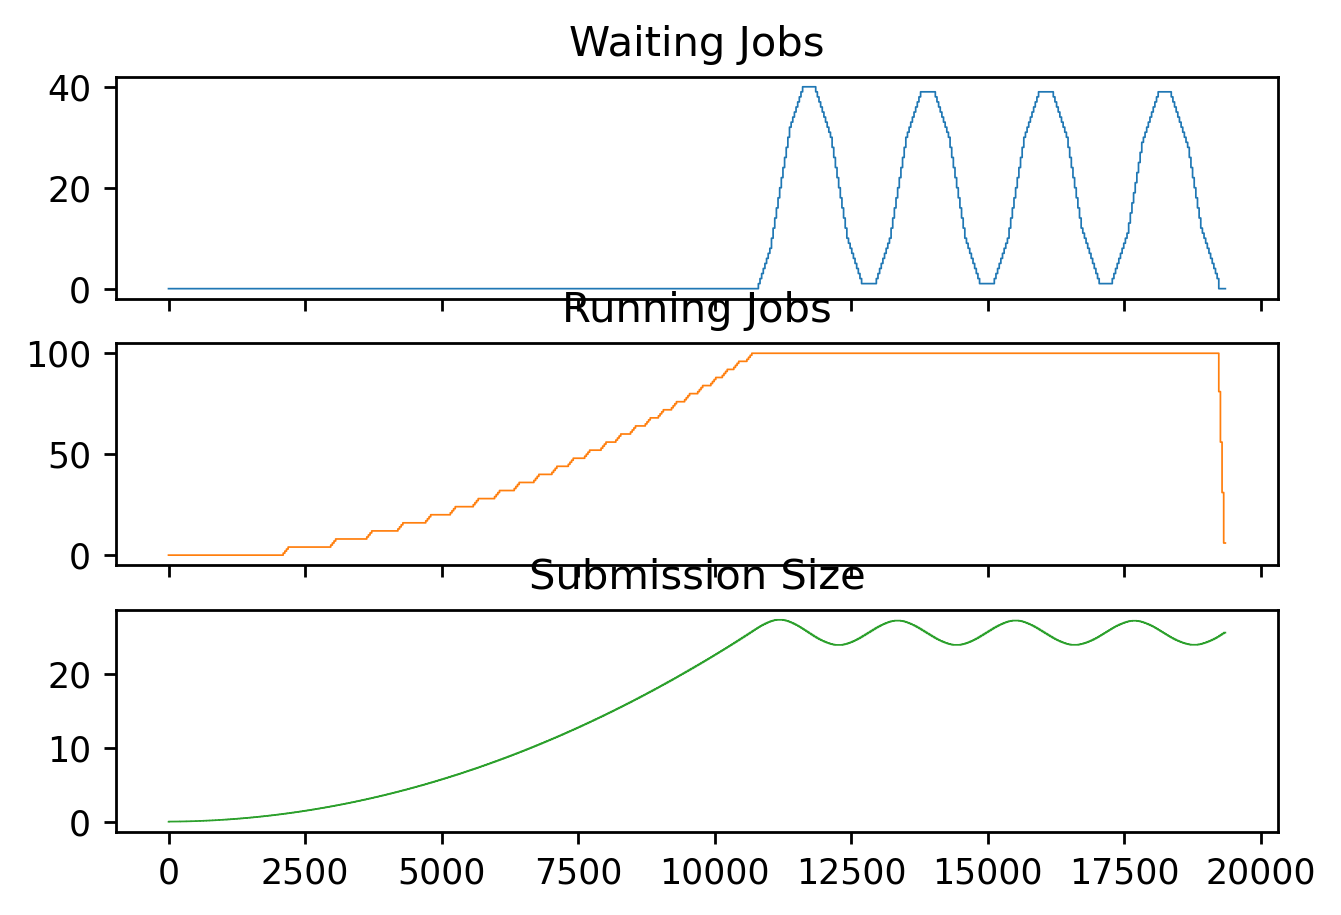

In [405]:
import numpy as np
import matplotlib.pyplot as plt

factor = 2.5
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*factor


df = np.array(data)
n = len(df)
fig, axs = plt.subplots(3, 1)
axs[0].step(df[0:n,0],df[0:n,1], linewidth=0.5)
axs[0].set_title('Waiting Jobs')
axs[1].step(df[0:n,0],df[0:n,2], 'tab:orange', linewidth=0.5)
axs[1].set_title('Running Jobs')
axs[2].step(df[0:n,0],df[0:n,3], 'tab:green', linewidth=0.5)
axs[2].set_title('Submission Size')
for ax in axs.flat:
    ax.label_outer()